<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "ACA,PL,ILA"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/BrainStructures/ACA,PL,ILA/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


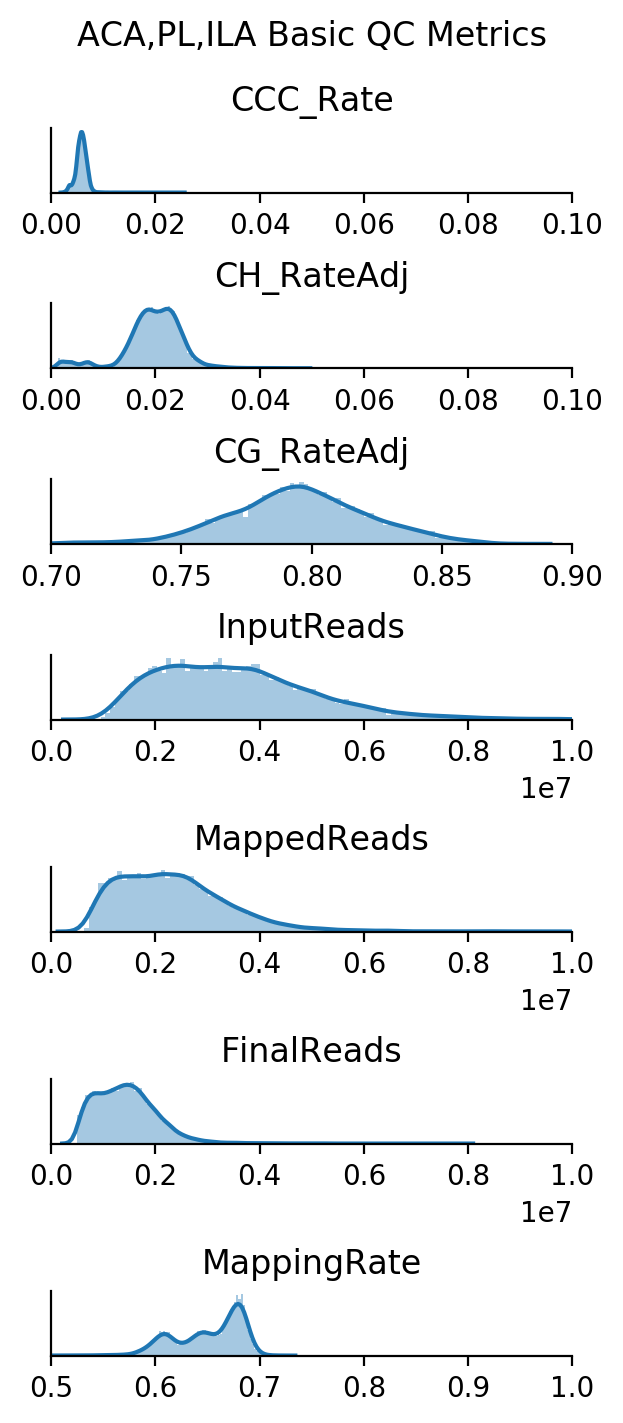

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

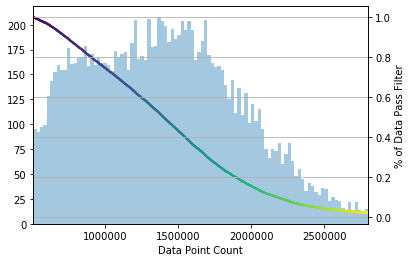

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 12518/12518 (100.0%)
CG_RateAdj passed 12518/12518 (100.0%)
CH_RateAdj passed 12518/12518 (100.0%)
FinalReads passed 12518/12518 (100.0%)
MappingRate passed 12518/12518 (100.0%)
Overall passed 12518/12518 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
180122 1144
180123 1375
180129 1347
180130 1243
180205 1167
180206 1252
190108 1315
190117 1308
190205 1243
190307 1124


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 1498 390.1%
ad002 1569 408.6%
ad004 1602 417.2%
ad006 1587 413.3%
ad007 1545 402.3%
ad008 1588 413.5%
ad010 1569 408.6%
ad012 1560 406.2%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,SubType,l3-umap_0,l3-umap_1,l3-tsne_0,l3-tsne_1,PassFilter
2A_M_0,/gale/raidix/rdx-4/CEMBA_RS1/2A/CEMBA180122_2A...,0.006500,0.818790,0.817600,0.032300,0.025970,1331460.0,3047360,2004297.0,2A,...,10.753746,-10.555482,17.199773,11.057664,IT-L5 Etv1,3.154834,2.472198,15.965073,25.370371,True
2A_M_1,/gale/raidix/rdx-4/CEMBA_RS1/2A/CEMBA180122_2A...,0.005490,0.809280,0.808230,0.024110,0.018720,1216036.0,2831092,1853507.0,2A,...,11.608352,-6.341986,-6.556243,-8.767269,IT-L6 Man1c1,-15.009007,-2.073336,14.962270,-32.302465,True
2A_M_10,/gale/raidix/rdx-4/CEMBA_RS1/2A/CEMBA180122_2A...,0.005230,0.786270,0.785150,0.022280,0.017140,1948720.0,4530404,3115528.0,2A,...,13.595753,-6.829616,19.896092,-11.896263,IT-L6 Fstl4,-9.226472,-1.121573,19.527408,15.474627,True
2A_M_100,/gale/raidix/rdx-4/CEMBA_RS1/2A/CEMBA180122_2A...,0.005300,0.802480,0.801430,0.021320,0.016110,1008760.0,2544422,1685858.0,2A,...,11.880907,-5.135264,-4.548552,-17.430347,IT-L6 Man1c1,-15.127828,-4.501793,25.655046,-22.560267,True
2A_M_1000,/gale/raidix/rdx-4/CEMBA_RS1/2A/CEMBA180122_2A...,0.004850,0.786780,0.785740,0.019400,0.014620,1439894.0,3135396,2116040.0,2A,...,1.157075,-7.886925,-26.512912,21.630406,IT-L23 Tenm2,2.183413,-2.931810,-1.812131,50.389296,True
2A_M_1002,/gale/raidix/rdx-4/CEMBA_RS1/2A/CEMBA180122_2A...,0.005070,0.814820,0.813880,0.027520,0.022560,1107837.0,2672060,1679876.0,2A,...,-22.408247,-15.505214,-19.478274,-51.031640,CGE-Lamp5 Sorcs1,-12.966360,8.935545,27.797531,-15.186962,True
2A_M_1003,/gale/raidix/rdx-4/CEMBA_RS1/2A/CEMBA180122_2A...,0.005680,0.798970,0.797820,0.028340,0.022790,1043871.0,2382596,1589848.0,2A,...,9.674395,8.120172,48.182829,15.420682,PT-L5 Ptprt,-15.907676,3.088457,-0.852315,21.885444,True
2A_M_1004,/gale/raidix/rdx-4/CEMBA_RS1/2A/CEMBA180122_2A...,0.004850,0.793160,0.792150,0.023210,0.018450,926697.0,2190218,1432895.0,2A,...,13.733252,-8.266196,3.245478,2.591133,IT-L6 Man1c1,-2.352561,-6.781085,-22.296413,-10.203387,True
2A_M_1005,/gale/raidix/rdx-4/CEMBA_RS1/2A/CEMBA180122_2A...,0.005710,0.825910,0.824910,0.027340,0.021750,776321.0,1760908,1181936.0,2A,...,-27.529964,3.927696,-1.181931,-19.129812,MGE-Pvalb Entpd3,2.476945,-5.244094,-8.038882,-24.849064,True
2A_M_1006,/gale/raidix/rdx-4/CEMBA_RS1/2A/CEMBA180122_2A...,0.004280,0.789620,0.788720,0.018160,0.013940,1140725.0,2405952,1648532.0,2A,...,1.682841,-7.226561,-26.928319,17.577827,IT-L23 Tenm2,1.234504,-4.694760,-6.030162,52.827791,True
